In [65]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math

In [5]:
acsee = pd.read_csv("CompleteDatasets/necta_acsee_2018.csv")
centersmeta = pickle.load(open('CompleteDatasets/centers_meta_2018.pkl', 'rb'))

In [114]:
#Any noticeable performance differences between smaller schools and larger schools?

divs = ['I', 'II', 'III', 'IV', '0']
divs_pass = ['I', 'II']

acsee['center'] = acsee['CNO'].apply(lambda x: x.split('/')[0])

def get_region(center, centers_meta):
    try:
        return centers_meta[center]['rankings'].loc[0][1]
    except AttributeError:
        return np.nan

def get_center_size(center, centers_meta):
    try:
        return centers_meta[center]['rankings'].loc[3][1]
    except AttributeError:
        return np.nan

def get_tester_type(center):
    if 'P' in center:
        return 'Private'
    else:
        return 'School'

acsee['region'] = acsee['center'].apply(lambda x: get_region(x, centersmeta))
acsee['centersize'] = acsee['center'].apply(lambda x: get_center_size(x, centersmeta))
acsee['testertype'] = acsee['center'].apply(lambda x: get_tester_type(x))
acsee['centersize'].value_counts() #This is the number of students/candidates within each group

CENTRE WITH 30 CANDIDATES OR MORE      74880
CENTRE WITH LESS THAN 30 CANDIDATES     2265
Name: centersize, dtype: int64

ValueError: math domain error

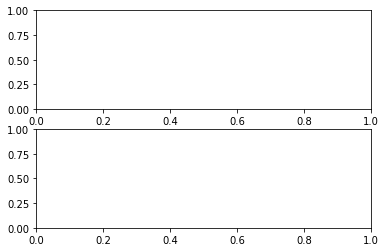

In [468]:
acsee[acsee['DIV'].isin(divs)].groupby([ 'centersize'])['center'].unique() #array of the unique centers in each centersize group
#Each center has a pass rate, that is proportion of I and IIs
#Schools by themselves don't have a pass/fail metric. We could check how many schools have at least 50% or 60% of their students
#pass though. That's why it's easier/more natural to say how many candidates in each grouping passed or failed. However,
#given the distribution of the different types of schools within Centre with 30 candidates or more, it may be worth it to look
#at the distribution of passing rates at each school within the groups. Does that reveal a noticeable difference 
#b/w the two groups?
acsee[acsee['DIV'].isin(divs_pass)]
acsee[acsee['DIV'].isin(divs)].groupby([ 'centersize'])['center'].value_counts() #students at each centersize-center, i.e. denom
acsee[acsee['DIV'].isin(divs_pass)].groupby([ 'centersize'])['center'].value_counts() #numerator
passing_rates_at_each_school = acsee[acsee['DIV'].isin(divs_pass)].groupby([ 'centersize'])['center'].value_counts()/acsee[acsee['DIV'].isin(divs)].groupby([ 'centersize'])['center'].value_counts()

fig, ax = plt.subplots(nrows = 2)
#Percentages might not be good for checking distributions because they are limited to between 0 and 1
#http://archive.bio.ed.ac.uk/jdeacon/statistics/tress4.html#Transformation%20of%20data says to take the arcsin
passing_rates_at_each_school['CENTRE WITH 30 CANDIDATES OR MORE'].apply(lambda x: math.asin(x*100)).plot(kind='hist', ax = ax[0], title = '30 or More',
                                                                      bins = 30)
passing_rates_at_each_school['CENTRE WITH LESS THAN 30 CANDIDATES'].apply(lambda x: math.asin(x*100)).plot(kind = 'hist', ax = ax[1], title = 'Less than 30',
                                                                        bins = 30)
fig.tight_layout()
print(passing_rates_at_each_school['CENTRE WITH 30 CANDIDATES OR MORE'].describe())
print(passing_rates_at_each_school['CENTRE WITH LESS THAN 30 CANDIDATES'].describe())

In [735]:
def get_pass(div):
    if div in divs_pass:
        return 1
    elif div in divs:
        return 0
    else:
        return np.nan
acsee['passed'] = acsee['DIV'].apply(lambda x: get_pass(x))

from scipy.stats import chisquare

#We need samples of each group

subsamples = []
for i in ['50-75', '300-900']:
    subsample = acsee[(acsee['new_centersize'] == i) & (acsee['testertype'] == 'School') & (acsee['center'] != 'S0485')].sample(frac = 0.09)
    subsamples.append(subsample)
acsee_new_center_sample = pd.concat(subsamples)
print(len(acsee_new_center_sample))

subsamples = []
for i in [e for e in acsee['centersize'].unique() if pd.notnull(e)]:
    subsample = acsee[(acsee['centersize'] == i) & (acsee['testertype'] == 'School')].sample(frac = 0.09)
    subsamples.append(subsample)
acsee_gov_center_sample = pd.concat(subsamples)
print(len(acsee_gov_center_sample))

def generate_chitable(df, which_size = 'centersize'):
    """Return chi square calculation ready table"""
    if which_size == 'centersize':
        observed_passed = df.groupby('centersize')['passed'].sum() #observed passed
        total_candidates = df.groupby('centersize')['passed'].count().rename("Total") #total
        observed_failed = (df.groupby('centersize')['passed'].count() - df.groupby('centersize')['passed'].sum()).rename("failed") #observed not passed
        chi_table = pd.concat([observed_passed, observed_failed, total_candidates], axis = 1)
        chi_table_horizontal_total = chi_table.sum().rename("Total")
        chi_table = chi_table.append(chi_table_horizontal_total)
        chi_table.index.rename("", inplace=True)
    else:
        observed_passed = df.groupby('new_centersize')['passed'].sum() #observed passed
        total_candidates = df.groupby('new_centersize')['passed'].count().rename("Total") #total
        observed_failed = (df.groupby('new_centersize')['passed'].count() - df.groupby('new_centersize')['passed'].sum()).rename("failed") #observed not passed
        chi_table = pd.concat([observed_passed, observed_failed, total_candidates], axis = 1)
        chi_table_horizontal_total = chi_table.sum().rename("Total")
        chi_table = chi_table.append(chi_table_horizontal_total)
        chi_table.index.rename("", inplace=True)
    
    return chi_table


def get_expected_values(chitable):
    """The return value is in the pattern of passed(row1), failed(row1), passed(row2), failed(row2)"""
    e_values = []
    for i in range(len(chitable)-1):
        passed_e = (chitable.iloc[i, 2] * chitable.iloc[len(chitable)-1,0])/chitable['Total']['Total']
        e_values.append(passed_e)
        failed_e = (chitable.iloc[i, 2] * chitable.iloc[len(chitable)-1,1])/chitable['Total']['Total']
        e_values.append(failed_e)
    return np.array(e_values)

def get_observed_values(chitable):
    """The return value is in the pattern of passed(row1), failed(row1), passed(row2), failed(row2)"""
    o_values = []
    for i in range(len(chitable)-1):
        passed_o = chitable.iloc[i,0]
        o_values.append(passed_o)
        failed_o = chitable.iloc[i,1]
        o_values.append(failed_o)
    passed1_obsv = chitable.iloc[0,0]
    failed1_obsv = chitable.iloc[0,1]
    passed2_obsv = chitable.iloc[1,0]
    failed2_obsv = chitable.iloc[1,1]
    return np.array(o_values)


#I find no significant differences between the official government groupings of the school, but the new groupings show
#there is a significant difference p < 0.05. Not surprisingly, the driver of this difference appears to be the 300-900 group.
#However, after removing the outlier schoool S0485, < 30 shows no significant difference in performance with 300-900 (now 600),
#but the 75-100 group still has significantly different passing rates. As do the other mid-tier schools.
print(chisquare(get_observed_values(generate_chitable(acsee_new_center_sample, "new_centersize")), get_expected_values(generate_chitable(acsee_new_center_sample, "new_centersize"))))

print(chisquare(get_observed_values(generate_chitable(acsee_gov_center_sample)), get_expected_values(generate_chitable(acsee_gov_center_sample))))

2399
6943
Power_divergenceResult(statistic=22.9181920153307, pvalue=4.200000546552685e-05)
Power_divergenceResult(statistic=1.7074268380393551, pvalue=0.6352839037416593)


In [687]:
acsee[acsee['DIV'].isin(divs)].groupby('center').count()['CNO'].sort_values(0)

center
S0176      1
P0540      1
P0989      1
P1199      1
P1291      1
P1625      1
P1430      1
P0550      2
S2299      2
P0549      2
P0742      2
P1264      2
S1518      2
S5450      2
P4624      2
P3811      2
P0618      3
P0355      3
P0370      3
P0402      3
P0123      3
S2295      3
P0167      3
S0376      3
P4236      4
S1339      4
P0313      4
P0514      4
S0909      4
P2213      4
        ... 
S0364    387
S0144    390
S0219    390
S0333    393
S0229    393
S0417    396
S0115    400
S0142    402
S0202    408
S0120    409
S0158    414
S0347    418
S0216    420
S0823    424
S0132    430
S0211    433
S0867    440
S0413    448
S0125    453
S1201    454
S0228    455
S0960    465
S0338    470
S0143    471
S0496    471
S0151    475
S0334    477
S0149    513
S2499    585
S0485    828
Name: CNO, Length: 904, dtype: int64

In [637]:
print(acsee[(acsee['centersize'] == "CENTRE WITH 30 CANDIDATES OR MORE") & (acsee['testertype'] == 'School')].sample())
print(subsample)
for e in [i for i in acsee['centersize'].unique() if pd.notnull(i)]:
    print(e)
    subsample = acsee[(acsee['centersize'] == e) & (acsee['testertype'] == 'School')].sample()
    subsamples.append(subsample)
acsee_gov_center_sample = pd.concat(subsamples)
print(len(acsee_gov_center_sample))

              CNO SEX AGGT DIV ACCOUNTANCY ADV/MATHS AGRICULTURE ARABIC BAM  \
47742  S0555/0531   F   11  II           X         X           X      X   X   

      BIOLOGY  ...   IS/KNOWLEDGE KISWAHILI PHYSICS  \
47742       X  ...              X         C       X   

                              centersize center region testertype numstudents  \
47742  CENTRE WITH 30 CANDIDATES OR MORE  S0555  TANGA     School        44.0   

      new_centersize passed  
47742          30-50    1.0  

[1 rows x 31 columns]
              CNO SEX AGGT  DIV ACCOUNTANCY ADV/MATHS AGRICULTURE ARABIC BAM  \
81821  S4019/0503   F   19   IV           X         X           X      X   X   
21099  S0164/0511   M   14  III           X         X           X      X   F   
63647  S0989/0505   M   13  III           X         X           X      X   X   
87120  S5333/0510   M   15  III           X         X           X      X   E   
42711  S0467/0510   M    9    I           X         X           X      X   X   
8018

In [43]:
#This is the % of students in each division
print("Centers with 30 candidates or more")
print(acsee[acsee['DIV'].isin(divs)].groupby('centersize')['DIV'].value_counts()['CENTRE WITH 30 CANDIDATES OR MORE']/acsee[acsee['DIV'].isin(divs)]['centersize'].value_counts()['CENTRE WITH 30 CANDIDATES OR MORE'])
print("\nCenters with less than 30 candidates")
print(acsee[acsee['DIV'].isin(divs)].groupby('centersize')['DIV'].value_counts()['CENTRE WITH LESS THAN 30 CANDIDATES']/acsee[acsee['DIV'].isin(divs)]['centersize'].value_counts()['CENTRE WITH LESS THAN 30 CANDIDATES'])

#The population size breakdown is the same order for each group DIV II is where most students land, followed by III, I, IV, 0
#+0.6% difference between divsion 0s. However, outside of a 2% difference between Division IIs, no noticeable diffs.

Centers with 30 candidates or more
DIV
II     0.442791
III    0.404741
I      0.106970
IV     0.032389
0      0.013109
Name: DIV, dtype: float64

Centers with less than 30 candidates
DIV
II     0.464143
III    0.402673
I      0.100223
IV     0.025835
0      0.007127
Name: DIV, dtype: float64


In [52]:
#Well that's surprising, why isn't there a noticeable difference between the students from the two types of centers? Let's check to see
#the spread of the number of students for each center.
acsee[acsee['DIV'].isin(divs)].groupby('region').count()['CNO'] #students per region
acsee[acsee['DIV'].isin(divs)].groupby(['center']).count()['CNO'] #students per center
acsee[acsee['DIV'].isin(divs)].groupby(['center', 'centersize']).count()['CNO'] #students per center with centersize

center  centersize                         
S0101   CENTRE WITH 30 CANDIDATES OR MORE      186
S0103   CENTRE WITH 30 CANDIDATES OR MORE      361
S0104   CENTRE WITH 30 CANDIDATES OR MORE      108
S0106   CENTRE WITH LESS THAN 30 CANDIDATES     21
S0107   CENTRE WITH 30 CANDIDATES OR MORE       75
S0108   CENTRE WITH 30 CANDIDATES OR MORE      383
S0109   CENTRE WITH 30 CANDIDATES OR MORE      364
S0110   CENTRE WITH 30 CANDIDATES OR MORE      173
S0111   CENTRE WITH LESS THAN 30 CANDIDATES     11
S0112   CENTRE WITH 30 CANDIDATES OR MORE      244
S0113   CENTRE WITH 30 CANDIDATES OR MORE       42
S0114   CENTRE WITH LESS THAN 30 CANDIDATES     18
S0115   CENTRE WITH 30 CANDIDATES OR MORE      400
S0116   CENTRE WITH 30 CANDIDATES OR MORE      151
S0117   CENTRE WITH 30 CANDIDATES OR MORE       34
S0118   CENTRE WITH LESS THAN 30 CANDIDATES     17
S0119   CENTRE WITH 30 CANDIDATES OR MORE      121
S0120   CENTRE WITH 30 CANDIDATES OR MORE      409
S0121   CENTRE WITH LESS THAN 30 CANDI

30 candidates or more - # of students distribution
 count    544.000000
mean     136.720588
std      110.745087
min       30.000000
25%       57.000000
50%      100.500000
75%      174.000000
max      828.000000
Name: CNO, dtype: float64
Less than 30 candidates - # of students distribution
 count    130.000000
mean      17.269231
std        7.561416
min        1.000000
25%       12.000000
50%       18.000000
75%       23.750000
max       29.000000
Name: CNO, dtype: float64


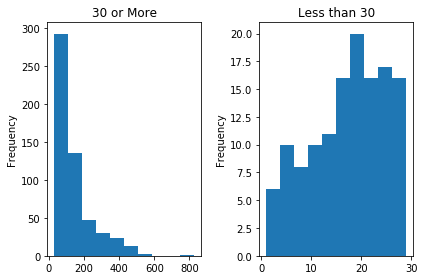

In [71]:
#Distribution of # of Students at the official size tiers
fig, (ax1, ax2) = plt.subplots(ncols = 2)
print("30 candidates or more - # of students distribution\n", acsee[acsee['DIV'].isin(divs)].groupby(['center', 'centersize']).count()['CNO'][:, 'CENTRE WITH 30 CANDIDATES OR MORE'].describe())
acsee[acsee['DIV'].isin(divs)].groupby(['center', 'centersize']).count()['CNO'][:, 'CENTRE WITH 30 CANDIDATES OR MORE'].plot(kind='hist', ax = ax1,
                                                                                                                            title = '30 or More')

print("Less than 30 candidates - # of students distribution\n", acsee[acsee['DIV'].isin(divs)].groupby(['center', 'centersize']).count()['CNO'][:, 'CENTRE WITH LESS THAN 30 CANDIDATES'].describe())
acsee[acsee['DIV'].isin(divs)].groupby(['center', 'centersize']).count()['CNO'][:, 'CENTRE WITH LESS THAN 30 CANDIDATES'].plot(kind='hist', ax = ax2,
                                                                                                                              title = 'Less than 30')
plt.close()
fig.tight_layout()
fig

In [111]:
#It seems it might be helpful to disaggregate the 30 or More group of schools
center_students = pd.DataFrame(acsee[acsee['DIV'].isin(divs)].groupby(['center']).count()['CNO']).reset_index()
center_students.rename(columns = {'CNO': 'numstudents'}, inplace=True)
len(center_students[(center_students['numstudents'] > 200) & (center_students['numstudents'] < 300)])

#Most are between 30 and 100 sutdents
#Possible new intervals 30-50, 50-75, 75-100, 100-200, 200-300, 300-900
new_sizes = ['30-50', '50-75', '75-100', '100-200', '200-300', '300-900']
new_sizes_dict = dict.fromkeys(new_sizes)
for k,v in new_sizes_dict.items():
    new_v = (int(k.split('-')[0]), int(k.split('-')[1]))
    new_sizes_dict[k] = new_v

for k,v in new_sizes_dict.items():
    print(len(center_students[(center_students['numstudents'] >= v[0]) & (center_students['numstudents'] < v[1])]))
#Not very scientifically done and groupings aren't as even as possible, but better distribution than 544 vs. 130. Let's see how
#performance compares for this new disaggregation

135
127
81
186
59
53


In [163]:
#center_students
acsee = acsee.merge(center_students, how = 'left', on='center')
#acsee['new_centersize'] = if numstudents is >= first val and < second val of the value, then return the key
new_sizes_dict['< 30'] = (0, 30)

def get_new_centersize(num, sizesdict):
    #rev sizesdict is tuple: 'interval'
    for k, v in sizesdict.items():
        if num >= v[0] and num < v[1]:
            return k

acsee['new_centersize'] = acsee['numstudents'].apply(lambda x: get_new_centersize(x, new_sizes_dict))
acsee['new_centersize'].unique()

#del acsee['numstudents_x'], acsee['numstudents_y'], acsee['new_centersize']

array(['50-75', '< 30', '100-200', '75-100', '30-50', '200-300',
       '300-900'], dtype=object)

In [193]:
list(new_sizes_dict.items())

[('30-50', (30, 50)),
 ('50-75', (50, 75)),
 ('75-100', (75, 100)),
 ('100-200', (100, 200)),
 ('200-300', (200, 300)),
 ('300-900', (300, 900)),
 ('< 30', (0, 30))]

In [411]:
#len(acsee[acsee.testertype == 'School'].groupby(['new_centersize', 'center'])['CNO'].count()['< 30']) should be 130
#We've successfully assigned new size groupings. Let's run the analysis again with the new center sizes:

fig, ax = plt.subplots(nrows = 7, figsize = (10,30))

for i in range(len(ax)):
    print(list(new_sizes_dict.items())[i][0], acsee[(acsee['DIV'].isin(divs)) & (acsee['testertype'] == 'School')].groupby(['center', 'new_centersize']).count()['CNO'][:, list(new_sizes_dict.items())[i][0]].describe())
    acsee[(acsee['DIV'].isin(divs)) & (acsee['testertype'] == 'School')].groupby(['center', 'new_centersize']).count()['CNO'][:, list(new_sizes_dict.items())[i][0]].plot(kind='hist', ax = ax[i], title = list(new_sizes_dict.items())[i][0])

plt.close()
fig.tight_layout()
fig.savefig("new_sizes_dist.png")

30-50 count    96.000000
mean     39.125000
std       5.423632
min      30.000000
25%      34.000000
50%      39.000000
75%      43.000000
max      49.000000
Name: CNO, dtype: float64
50-75 count    103.000000
mean      61.087379
std        7.341938
min       50.000000
25%       54.500000
50%       61.000000
75%       67.000000
max       74.000000
Name: CNO, dtype: float64
75-100 count    70.000000
mean     85.414286
std       7.198013
min      75.000000
25%      79.000000
50%      85.000000
75%      91.750000
max      99.000000
Name: CNO, dtype: float64
100-200 count    167.000000
mean     140.598802
std       27.942510
min      100.000000
25%      117.500000
50%      137.000000
75%      162.000000
max      197.000000
Name: CNO, dtype: float64
200-300 count     56.000000
mean     247.250000
std       30.850519
min      200.000000
25%      222.750000
50%      241.000000
75%      276.250000
max      299.000000
Name: CNO, dtype: float64
300-900 count     52.000000
mean     404.288462
std

In [205]:
#The distributions look better and should allow us to better compare the performance at each size tier
for i in range(7):
    tier = list(new_sizes_dict.items())[i][0]
    print(tier,
          acsee[(acsee['DIV'].isin(divs)) & (acsee['testertype'] == 'School')].groupby(['new_centersize'])['DIV'].value_counts()[tier]/acsee[(acsee['DIV'].isin(divs)) & (acsee['testertype'] == 'School')]['new_centersize'].value_counts()[tier])

30-50 DIV
II     0.465921
III    0.395634
I      0.099308
IV     0.030618
0      0.008520
Name: DIV, dtype: float64
50-75 DIV
II     0.481087
III    0.374285
I      0.105849
IV     0.027177
0      0.011602
Name: DIV, dtype: float64
75-100 DIV
II     0.486871
III    0.331159
I      0.148520
IV     0.025757
0      0.007694
Name: DIV, dtype: float64
100-200 DIV
II     0.450894
III    0.388756
I      0.122104
IV     0.027768
0      0.010477
Name: DIV, dtype: float64
200-300 DIV
II     0.435577
III    0.428427
I      0.088545
IV     0.033078
0      0.014372
Name: DIV, dtype: float64
300-900 DIV
III    0.438662
II     0.410360
I      0.092090
IV     0.040860
0      0.018028
Name: DIV, dtype: float64
< 30 DIV
II     0.464143
III    0.402673
I      0.100223
IV     0.025835
0      0.007127
Name: DIV, dtype: float64


In [414]:
#The new acceptable way to make categorical variables - unused for now, instead can use .reindex method
from pandas.api.types import CategoricalDtype
div_order = ['ABS', '*E', '*R', '*W', '0', 'IV', 'III', 'II', 'I'] #All values must be included in this list, otherwise will be turned to NaN when cat'd
acsee['DIV'] = acsee['DIV'].astype(CategoricalDtype(div_order, ordered=True))

fig, ax = plt.subplots(nrows=7, figsize = (10,20))
for i in range(7):
    tier = ([list(new_sizes_dict.items())[-1]] + (list(new_sizes_dict.items())[0:-1]))[i][0]
    print(tier,
          (acsee[(acsee['DIV'].isin(divs)) & (acsee['testertype'] == 'School')].groupby(['new_centersize'])['DIV'].value_counts()[tier]/acsee[(acsee['DIV'].isin(divs)) & (acsee['testertype'] == 'School')]['new_centersize'].value_counts()[tier]).reindex(divs).plot(kind='bar', ax = ax[i], title = tier, color = 'navy', rot=0))
    


plt.close()
fig.tight_layout()
fig.savefig("new_tiers_div_percentage_dist.png")

#Doing the same as above, but plotting instead, it's easier to see how the trend holds for every size tier except the largest.
#The most promising size tier appears to be the 75-100 group. Does this tier correlate to any region?

< 30 AxesSubplot(0.125,0.787927;0.775x0.0920732)
30-50 AxesSubplot(0.125,0.677439;0.775x0.0920732)
50-75 AxesSubplot(0.125,0.566951;0.775x0.0920732)
75-100 AxesSubplot(0.125,0.456463;0.775x0.0920732)
100-200 AxesSubplot(0.125,0.345976;0.775x0.0920732)
200-300 AxesSubplot(0.125,0.235488;0.775x0.0920732)
300-900 AxesSubplot(0.125,0.125;0.775x0.0920732)


In [283]:
#Mtwara, the highest performing region, only had 5% of its schools in the 75-100 students size tier
#Kaskazini Pemba, the third lowest performing region, had the highest share of its schools in that tier.
#Not too surprisingly, having a greater concentration of the best performing tier doesn't necessarily translate to performance.
numschoolstier75 = acsee[(acsee['new_centersize'] == '75-100') & (acsee['DIV'].isin(divs))]['region'].value_counts()
(numschoolstier75/acsee[(acsee['DIV'].isin(divs))]['region'].value_counts()).sort_values(0)

KAGERA             0.020957
MOROGORO           0.023779
MBEYA              0.037378
MTWARA             0.050033
KILIMANJARO        0.055772
PWANI              0.059384
GEITA              0.063665
DAR ES SALAAM      0.063899
MWANZA             0.064910
RUKWA              0.066863
RUVUMA             0.070297
MARA               0.079221
TABORA             0.093701
IRINGA             0.111759
LINDI              0.116059
ARUSHA             0.117102
SONGWE             0.121116
SHINYANGA          0.145032
TANGA              0.147808
SIMIYU             0.195542
DODOMA             0.200765
SINGIDA            0.276596
MANYARA            0.325000
KASKAZINI PEMBA    0.476923
KATAVI                  NaN
KIGOMA                  NaN
KUSINI PEMBA            NaN
MJINI MAGHARIBI         NaN
NJOMBE                  NaN
Name: region, dtype: float64

In [403]:
#For the top performing schools, what's their size tier distributions?
#For the top 3 schools, find their size tier distributions (total number of schools at each tier)
top3numschools = pd.DataFrame(acsee[(acsee['DIV'].isin(divs))].groupby(['region'])['new_centersize'].value_counts()[['GEITA', 'MTWARA', 'LINDI']] )
top3numschools.columns = ['numschools']
top3numschools.reset_index(inplace=True)
top3numschools.set_index(['region', 'new_centersize'], inplace=True)

#In order to divide just the three schools (or other select schools), the indices of the dividend/divisor need to match.
#This is simple for a single index situation, but trickier for multi-index especially since the divisor is not a scalar -
#the divisor is the total number of schools in the region in question. We elect to have a multi-index so that we can have
#clear size tier labels for the region without assuming. So we have to replicate the dividend dataframe, add the multi-indices as
#columns of the new dataframe (totalschools), reset so that we can map total values (which are scalars) based on the region,
#set the multi-index for the new dataframe (totalschools), then divide the two series.

totalschools = pd.DataFrame(index = top3numschools.index, columns = ['totalschools']).reset_index()
schooltotals = dict(list(acsee[(acsee['DIV'].isin(divs))]['region'].value_counts()[list(top3numschools.index.levels[0])].items()))
totalschools['totalschools'] = totalschools['region'].apply(lambda x: schooltotals[x] ) #if region is x, put y values
totalschools.set_index(['region', 'new_centersize'], inplace=True)
top3numschools['numschools']/totalschools['totalschools']

#Once again, if 75-100 seems to appear to be the _most_ optimal school size tier, it's a small proportion of the schools
#that are found in the highest performing regions. Suggesting that their success is not driven by tier size.
#A regression idea: passing % = size_tier_dummies + region_control

region  new_centersize
GEITA   100-200           0.690994
        200-300           0.184006
        75-100            0.063665
        50-75             0.043478
        < 30              0.017857
LINDI   100-200           0.443995
        200-300           0.275304
        75-100            0.116059
        50-75             0.097166
        < 30              0.067476
MTWARA  100-200           0.349566
        300-900           0.313542
        200-300           0.197465
        75-100            0.050033
        50-75             0.034690
        30-50             0.030020
        < 30              0.024683
dtype: float64

In [425]:
#If Kaskazini Pemba's 75-100 tier schools didn't carry it to the finish line, how did
#the rest of the other regions' 75-100 tier schools do?
numschoolstier75
tier75passing = acsee[(acsee['DIV'].isin(divs_pass)) & (acsee['testertype'] == 'School') & (acsee['new_centersize'] == '75-100')].groupby('region').count()['CNO']

(tier75passing/numschoolstier75).sort_values(0, ascending=False)

#numschoolstier is actually number of candidates in that tier - FIX REFERENCES ABOVE
#If this is the spread for this tier, what about the other tiers?

GEITA              0.975610
MTWARA             0.973333
PWANI              0.873418
LINDI              0.802326
RUKWA              0.780220
MANYARA            0.760000
TANGA              0.758373
SINGIDA            0.754986
DAR ES SALAAM      0.668213
DODOMA             0.657143
SONGWE             0.643979
TABORA             0.638655
SHINYANGA          0.624309
KILIMANJARO        0.613953
MARA               0.594286
MWANZA             0.572727
SIMIYU             0.549223
ARUSHA             0.546512
MBEYA              0.527778
IRINGA             0.519274
KAGERA             0.447059
RUVUMA             0.422131
MOROGORO           0.320000
KASKAZINI PEMBA    0.258065
dtype: float64